# Height data

In [48]:
import torch
import pyro
import pyro.distributions as dist
from pyro import param
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve

from scipy.io import loadmat

### Results

Tracker v1.1.3flat

In [21]:
D = 14
background = 150
gain = torch.tensor(7.)
width = torch.tensor([1.4])

rv = dist.MultivariateNormal(
    torch.tensor([6.5, 6.5]),
    scale_tril=torch.eye(2) * width[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

# calculate signal-to-noise ratio
heights = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]
snr = []
for h in heights:
    weights = rv.log_prob(ij_pixel).exp()
    signal = (weights ** 2 * float(h)).sum()
    noise = ((signal+background) * gain).sqrt()
    snr.append(float(signal / noise))

In [56]:
pi_z = "15"
params_last = {}
predictions = {}
labels = {}

names = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]

for name in names:
    path_data = "/shared/centaur/data/height_data/h{}pi15lamda15".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.4prox/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        os.path.join(path_data, "runs/tracker/v1.1.4prox/S1/control/lr0.005/bs5/predictions.npy"))
    labels[name] = np.load(os.path.join(path_data, "labels.npy"))

In [57]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
scores_v1p13["SNR"] = snr
scores_v1p13

,iter,-ELBO,proximity_0,gain,pi_1,lamda_1,offset_samples_0,offset_weights_0,MCC,Recall,Precision,FN,TP,TN,FP,SNR
0300,19900.0,14369599.0,0.5,7.024103,0.000549,0.000003,89.500015,1.0,0.038008,0.001711,1.000000,1167.0,2.0,6331.0,0.0,0.361499
0500,19900.0,14385839.0,0.5,7.086080,0.031702,0.000299,89.500015,1.0,0.337358,0.152267,0.898990,991.0,178.0,6311.0,20.0,0.587959
0750,19900.0,14402907.0,0.5,7.139011,0.136957,0.014463,89.500015,1.0,0.789896,0.750214,0.894898,292.0,877.0,6228.0,103.0,0.856776
1000,19900.0,14425803.0,0.5,7.137791,0.173040,0.053517,89.500015,1.0,0.909795,0.964927,0.885400,41.0,1128.0,6185.0,146.0,1.111534
1500,19900.0,14449852.0,0.5,7.134382,0.169695,0.100317,89.500015,1.0,0.940534,0.986313,0.915079,16.0,1153.0,6224.0,107.0,1.585028
2000,28900.0,14462731.0,0.5,7.122168,0.169628,0.117254,89.500015,1.0,0.945980,0.991446,0.919112,10.0,1159.0,6229.0,102.0,2.018458
3000,19900.0,14493672.0,0.5,7.185188,0.170760,0.125390,89.500015,1.0,0.953628,0.995723,0.927490,5.0,1164.0,6240.0,91.0,2.792414


In [20]:
sp_results = {}

for name in names:
    sp_results[name] = loadmat("/shared/centaur/data/height_data/h{}.mat".format(name))

In [13]:
scores_sp = pd.DataFrame(data={
    "spMCC": [matthews_corrcoef(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
    "spRecall": [recall_score(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
    "spPrecision": [precision_score(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
    },
    index=names)
scores_sp

,spMCC,spRecall,spPrecision
0300,0.347883,0.166809,0.878378
0500,0.570095,0.420873,0.888087
0750,0.759349,0.685201,0.912301
1000,0.872431,0.858854,0.925346
1500,0.941323,0.974337,0.927524
2000,0.950915,0.984602,0.933496
3000,0.951547,0.980325,0.938575


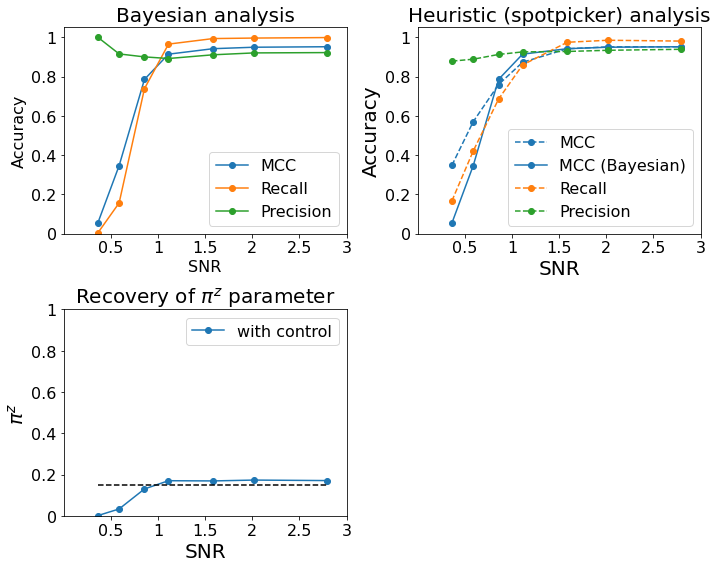

In [52]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,3)
plt.xlabel(r"SNR", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,7)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,3)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,7)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.subplot(223)
plt.plot(snr, scores_v1p13["pi_1"], "o-", label="with control")
plt.plot([snr[0], snr[-1]], [float(pi_z)/100, float(pi_z)/100], "--", c="k")
plt.ylim(0,1)
plt.xlim(0,3)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel(r"$\pi^z$", fontsize=20)
plt.title(r"Recovery of $\pi^z$ parameter", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,7)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

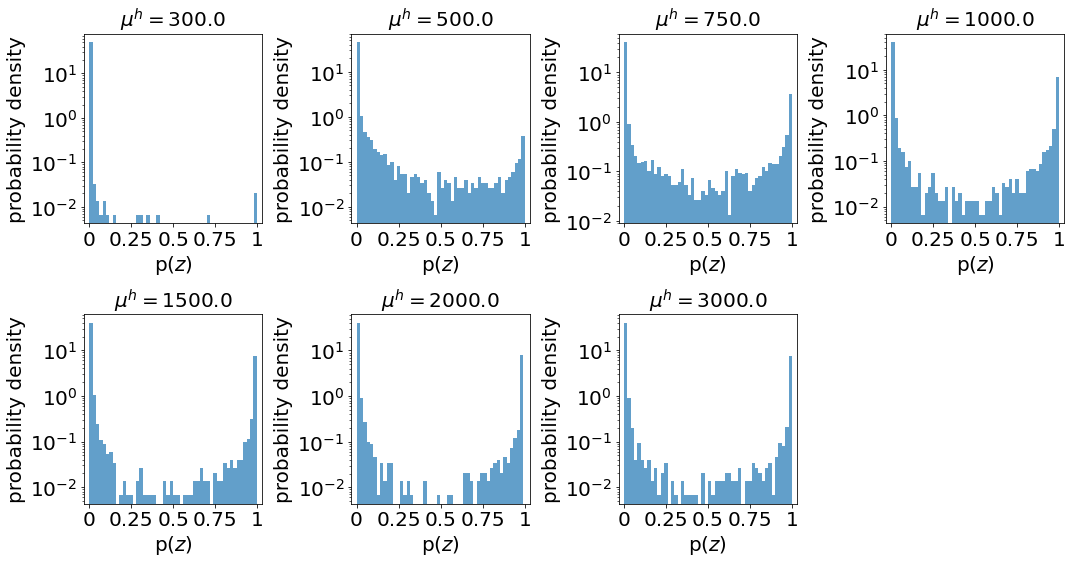

In [49]:
plt.figure(figsize=(15,15))
for i, h in enumerate(heights):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[h]["z_prob"].ravel(), bins=50, density=True, alpha=0.7)
    plt.xlim(-0.03, 1.03)
    plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

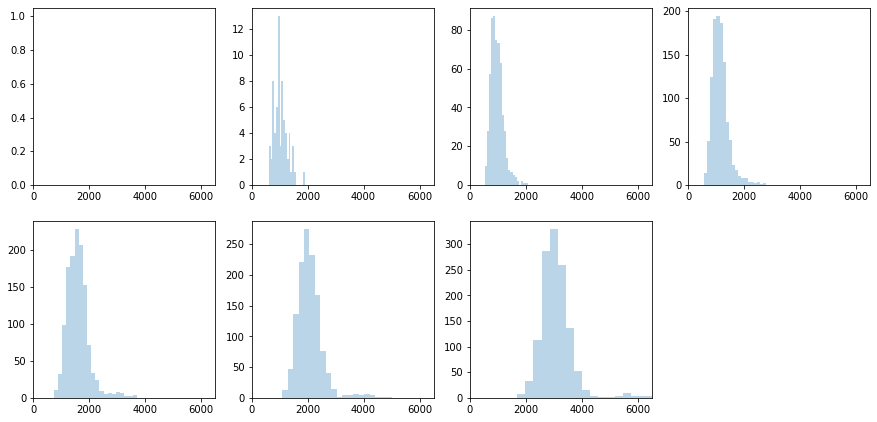

In [41]:
plt.figure(figsize=(15,15))
for i, name in enumerate(heights):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/height_data/h{}pi15lamda15".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/h_loc").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(0, 6500)
plt.show()

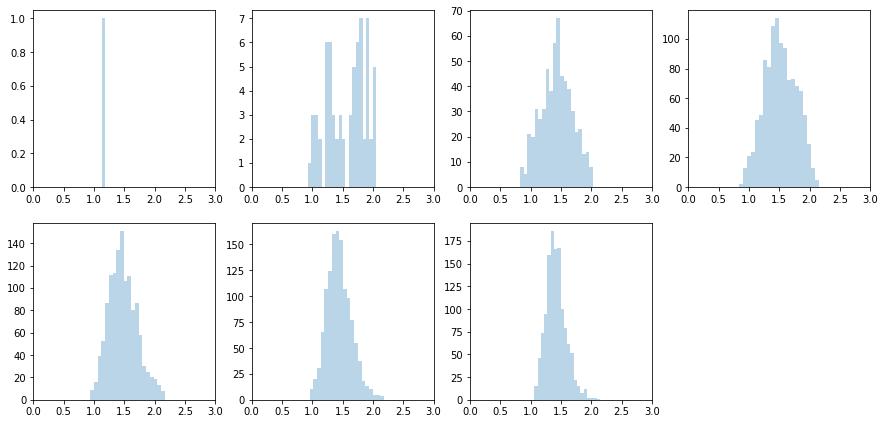

In [44]:
plt.figure(figsize=(15,15))
for i, name in enumerate(heights):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/height_data/h{}pi15lamda15".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/w_mode").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(0, 3)
plt.show()

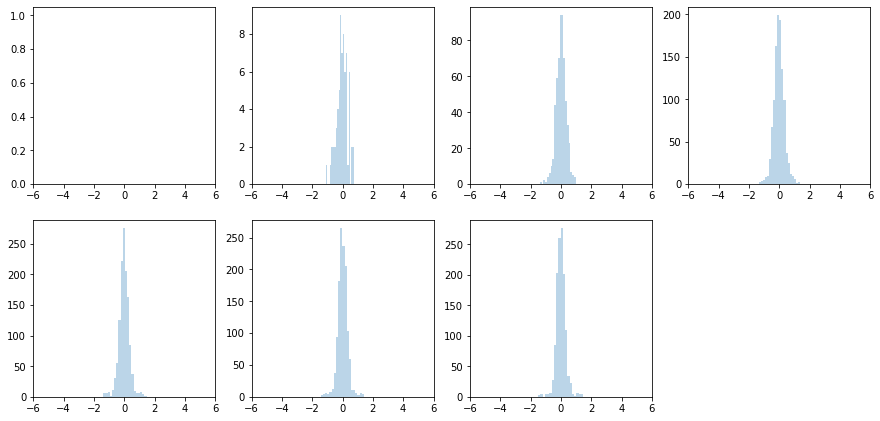

In [46]:
plt.figure(figsize=(15,15))
for i, name in enumerate(heights):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/height_data/h{}pi15lamda15".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/x_mode").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(-6, 6)
plt.show()